In [1]:
import os
import json
import pandas as pd

#https://drive.google.com/drive/folders/18qV82fNY3IIWu3BRoGqm_LNgJzE8Akbr?usp=drive_link
#base_dir = "/Users/Andypon/10_交大研究所/1141_01_機器學習與金融科技/data"
base_dir= '/Users/andyw.p.chen/Documents/Project/datasets'
#base_dir=  "c:\Users\user\Downloads\datasets"

def load_json_to_df(filename: str) -> pd.DataFrame:
    file_path = os.path.join(base_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 如果是 { "target": {id: value, ...} }
    if isinstance(data, dict) and len(data) == 1 and isinstance(next(iter(data.values())), dict):
        key, inner = next(iter(data.items()))
        return pd.DataFrame(list(inner.items()), columns=["id", key])

    # dict of scalar
    if isinstance(data, dict):
        return pd.DataFrame([{"code": k, "desc": v} for k, v in data.items()])

    # list of dict
    elif isinstance(data, list):
        return pd.DataFrame(data)

    else:
        raise ValueError(f"Unsupported JSON structure in {filename}: {type(data)}")


def load_csv_to_df(filename: str) -> pd.DataFrame:
    """讀取 CSV 並轉為 DataFrame。"""
    return pd.read_csv(os.path.join(base_dir, filename))

# JSON 資料
##mcc_codes_df = load_json_to_df("mcc_codes.json")
train_fraud_labels_df = load_json_to_df("train_fraud_labels.json")

# CSV 資料
cards_df = load_csv_to_df("cards_data.csv")
transactions_df = load_csv_to_df("transactions_data.csv")
users_df = load_csv_to_df("users_data.csv")

# 簡單檢查
#print(mcc_codes_df.head())
#print(train_fraud_labels_df.head())
#print(cards_df.head())
#print(transactions_df.head())
#print(users_df.apthead())

train_fraud_labels_df = train_fraud_labels_df.rename(columns={'id': 'transactions_id'})
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'target': 'is_fraud'})

cards_df = cards_df.rename(columns={'id':'card_id'})

users_df = users_df.rename(columns={'id':'client_id'})

transactions_df = transactions_df.rename(columns={'mcc': 'mcc_code'})
transactions_df = transactions_df.rename(columns={'id': 'transaction_id'})

def add_missing_flags(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    在 DataFrame 中對指定欄位建立 missing flag 欄位
    flag=1 表示缺失值，flag=0 表示非缺失值
    
    參數
    ----
    df : pd.DataFrame
        輸入的資料框
    cols : list
        要檢查的欄位名稱清單
    
    回傳
    ----
    pd.DataFrame : 新的資料框 (含新增的 flag 欄位)
    """
    for col in cols:
        df[f"{col}_missing_flag"] = df[col].isna().astype(int)
    return df

transactions_df = add_missing_flags(transactions_df, ["merchant_state", "zip", "errors"])

##train_fraud_labels_df##
train_fraud_labels_df["is_fraud"]=train_fraud_labels_df["is_fraud"].astype("category") 
train_fraud_labels_df["transactions_id"]=train_fraud_labels_df["transactions_id"].astype(int) #合併資料需要

##cards_df##
cards_df["card_brand"]=cards_df["card_brand"].astype("category") 
cards_df["card_type"]=cards_df["card_type"].astype("category")
#####不要load這行 cards_df["expires"]=pd.to_datetime(cards_df["expires"], format="%m/%Y")
cards_df["expires"] = pd.to_datetime(cards_df["expires"], format="%m/%Y").dt.to_period("M")
cards_df["has_chip"]=cards_df["has_chip"].astype("category")

cards_df['credit_limit'] = cards_df['credit_limit'].replace(r'[\$,]', '', regex=True).astype(int)
#####不要load這行 cards_df["acct_open_date"]=pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y")
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y").dt.to_period("M")
#####不要load這行 cards_df["year_pin_last_changed"]=pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y")
cards_df["year_pin_last_changed"] = pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y").dt.to_period("Y")
cards_df["card_on_dark_web"]=cards_df["card_on_dark_web"].astype("category") 

##users_df##
users_df["birth_year"] = pd.to_datetime(users_df["birth_year"], format="%Y").dt.to_period("Y")
users_df["birth_month"] = pd.to_datetime(users_df["birth_month"], format="%m").dt.to_period("M")
users_df["gender"]=users_df["gender"].astype("category") 
users_df['per_capita_income'] = users_df['per_capita_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['yearly_income'] = users_df['yearly_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['total_debt'] = users_df['total_debt'].replace(r'[\$,]', '', regex=True).astype(int)

##transactions_df##
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
#浮點數轉整數原因確定？
transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float).astype(int)
##負數取log調成1
#transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float)

transactions_df["use_chip"]=transactions_df["use_chip"].astype("category") 

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'merchant_state'
] = 'online'

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'zip'
] = -1
## 我沒有全部改，這樣完之後仍有89006筆Missing，剩下都是在國外
transactions_df['zip'] = transactions_df['zip'].fillna(-999)
transactions_df["zip"]=transactions_df["zip"].astype("int64")

transactions_df['errors'] = transactions_df['errors'].astype('category')
transactions_df['errors'] = transactions_df['errors'].cat.add_categories('No_error').fillna('No_error')


#cars one hot encoding
##統一類別變數轉dummy variable(要注意共線性問題，應刪掉其中之一)

#card_type 原始種類：Debit_57%, Credit_33%, Debit(Prepaid)_9%
#card_brand 原始種類：MasterCard_52%, Visa_38%, Amex_7%, Discovery_3%
#has_chip 原始種類：Yes_89%, No_11%
#card_on_dark_web 原始種類：No_0%
cols_to_encode = ['card_type', 'card_brand', 'has_chip']
cards_df[cols_to_encode] = cards_df[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    cards_df[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
cards_df = pd.concat([cards_df, dummies_cards], axis=1)

#use_chip 原始種類：Swiped_52%, Chipe_36%, Online_12%
dummies_use = pd.get_dummies(transactions_df['use_chip'], prefix='use_chip', dtype='uint8')
transactions_df = pd.concat([transactions_df, dummies_use], axis=1)

#gender 原始種類：Female_51%, Male_49%
dummies_gender = pd.get_dummies(users_df['gender'], prefix='gender', dtype='uint8')
users_df = pd.concat([users_df, dummies_gender], axis=1)


cards_df.drop(columns=["has_chip_NO","has_chip"], inplace=True)
transactions_df.drop(columns=["use_chip"], inplace=True)
users_df.drop(columns=["gender_Female"], inplace=True)

#transactions_df.loc[transactions_df["transaction_id"] == 10649266] #transaction_id vs id

#原始資料筆數：13305915
### transactions_df+train_fraud_labels_df      left 會有4390952 missing values
merged = pd.merge(transactions_df, train_fraud_labels_df, left_on="transaction_id", right_on="transactions_id", how="outer")
### transactions_df train_fraud_labels_df(8914963) + users_df 對過去不會有missing values
merged = pd.merge(merged,users_df , left_on="client_id", right_on="client_id", how="left")
### transactions_df train_fraud_labels_df users_df + cards_df 對過去不會有missing values
merged = pd.merge(merged,cards_df , left_on="card_id", right_on="card_id", how="left")

#刪掉重複的columns
merged.drop(columns=["transactions_id"], inplace=True)
merged.drop(columns=["client_id_y"], inplace=True)

del transactions_df, users_df, cards_df, train_fraud_labels_df

merged["is_fraud"] = merged["is_fraud"].astype(str)
merged.loc[merged['is_fraud'].str.lower() == 'no','is_fraud'] = '0'
merged.loc[merged['is_fraud'].str.lower() == 'yes','is_fraud'] = '1'
merged["is_fraud"] = pd.to_numeric(merged["is_fraud"], errors="coerce").astype("Int64")

merged = add_missing_flags(merged, ["is_fraud"])

#merged.to_csv("merged.csv", index=False)

del cols_to_encode, dummies_cards, dummies_use, dummies_gender

In [2]:
num_cols = merged.select_dtypes(include=['int64', 'float64','uint8']).columns
df=merged[num_cols]

df_cleaned = df.dropna()
del df
df_cleaned.drop(columns=["is_fraud_missing_flag","card_type_Debit (Prepaid)", "card_brand_Discover", "use_chip_Online Transaction"], inplace=True)

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=888)

del df_cleaned, merged
trainp = train_df['is_fraud'].value_counts(normalize=False)
print(trainp)
testp = test_df['is_fraud'].value_counts(normalize=False)
print(testp)

is_fraud
0    7121379
1      10591
Name: count, dtype: Int64
is_fraud
0    1780252
1       2741
Name: count, dtype: Int64


In [3]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    # 1. 保留數值欄位
    df_num = df.select_dtypes(include=[np.number]).copy()

    # 2. 強制轉成 float64，避免 Int64 / uint8 / object 問題
    df_num = df_num.astype(np.float64)

    # 3. 檢查 inf / NaN
    if not np.isfinite(df_num.values).all():
        raise ValueError("Data contains NaN or infinite values, cannot compute VIF.")

    # 4. 加上截距
    X = sm.add_constant(df_num)

    # 5. 計算 VIF
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) 
                         for i in range(X.shape[1])]

    return vif

# 共線性觀察
#vif_result = calculate_vif(train_df)
#print(vif_result.sort_values(by="VIF Factor", ascending=False).head(10))

##第一次處理共線性
train_df.drop(columns=["per_capita_income"], inplace=True)
##觀察card_number的異常處
#print(train_df["card_number"].nunique(), "/", len(train_df))
##第一次處理card_number
train_df.drop(columns=["card_number"], inplace=True)
#再重跑一次VIF
#vif_result = calculate_vif(train_df)
#print(vif_result.sort_values(by="VIF Factor", ascending=False).head(10))
##發現missing_flag的共線性問題，決定保留one hot encoding高vif值的變數
train_df.drop(columns=["zip_missing_flag","merchant_state_missing_flag"], inplace=True)
#vif_result = calculate_vif(train_df)
#print(vif_result.sort_values(by="VIF Factor", ascending=False).head(10))
##移除missing_flag共線性問題，再次確認

In [4]:
import statsmodels.api as sm

# assume train_df is your dataframe and "is_fraud" is the dependent variable
y = train_df["is_fraud"]

# exclude the dependent variable itself
independent_vars = train_df.columns.drop("is_fraud")

results = []

for var in independent_vars:
    X = sm.add_constant(train_df[var])  # add intercept
    model = sm.Logit(y, X)
    try:
        result = model.fit(disp=False)
        coef = result.params[var]
        pval = np.around(result.pvalues[var], 4)
        results.append({"variable": var, "coefficient": coef, "p_value": pval})
    except Exception as e:
        results.append({"variable": var, "coefficient": None, "p_value": None})
        print(f"Skipped {var} due to error: {e}")

# convert to dataframe
summary_df = pd.DataFrame(results)

# optional: sort by p_value
summary_df = summary_df.sort_values("p_value", ascending=True).reset_index(drop=True)

print(summary_df)

                      variable   coefficient  p_value
0    use_chip_Chip Transaction -5.792166e-01   0.0000
1              card_type_Debit -2.431305e-01   0.0000
2             card_type_Credit  1.187650e-01   0.0000
3                       amount  2.634523e-03   0.0000
4                  merchant_id  5.815498e-06   0.0000
5                          zip -1.023342e-04   0.0000
6                     mcc_code -5.383161e-04   0.0000
7          errors_missing_flag -1.034501e+00   0.0000
8                   total_debt -1.507820e-06   0.0000
9   use_chip_Swipe Transaction -2.282721e+00   0.0000
10                 current_age  6.811940e-03   0.0000
11                credit_limit -1.325726e-05   0.0000
12                    latitude -8.201997e-03   0.0000
13            num_credit_cards  1.108020e-01   0.0000
14               yearly_income -4.518766e-06   0.0000
15                has_chip_YES  1.266255e-01   0.0002
16                credit_score  4.469540e-04   0.0027
17                   longitu

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.stats import chi2

def _compute_cov_and_se(model, X_scaled):
    """
    根據已訓練的 sklearn LogisticRegression model 與已 scale 過的 X，
    使用 observed Fisher information matrix 計算共變異數矩陣與標準誤。
    回傳 (cov_matrix, se_array)；se_array 包含 intercept 的 se 在 index 0。
    """
    n = X_scaled.shape[0]
    # design matrix with intercept
    X_design = np.hstack([np.ones((n, 1)), X_scaled])
    p = model.predict_proba(X_scaled)[:, 1]
    W = p * (1 - p)
    # compute X' W X
    XtWX = X_design.T @ (W[:, None] * X_design)
    # try inverse, 若 singular 則用 pseudo-inverse
    try:
        cov = np.linalg.inv(XtWX)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(XtWX)
    se = np.sqrt(np.maximum(np.diag(cov), 0.0))
    return cov, se

def compute_not_in_eq(y_train, X_train, included, excluded_vars):
    """
    對每一個 excluded variable 做單變量 logistic（含 intercept）並計算 Wald & p-value。
    回傳 DataFrame，欄位: Independent Variable, Wald, Sig.
    """
    results = []
    for var in excluded_vars:
        try:
            # 保證 numeric
            X_var = X_train[[var]].astype(float)
            scaler = StandardScaler()
            X_var_scaled = scaler.fit_transform(X_var)

            model = LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=1000)
            model.fit(X_var_scaled, y_train)

            coef = model.coef_[0][0]
            cov, se = _compute_cov_and_se(model, X_var_scaled)
            # se[0] is intercept se, se[1] is variable se
            se_var = se[1] if len(se) > 1 else np.nan

            if se_var == 0 or np.isnan(se_var):
                wald = np.nan
                pval = np.nan
            else:
                wald = (coef / se_var) ** 2
                pval = float(chi2.sf(wald, df=1))

            results.append({
                "Independent Variable": var,
                "Wald": round(float(wald), 3) if not np.isnan(wald) else None,
                "Sig.": round(float(pval), 4) if not np.isnan(pval) else None
            })
        except Exception:
            results.append({
                "Independent Variable": var,
                "Wald": None,
                "Sig.": None
            })

    return pd.DataFrame(results)


def sklearn_logit_with_k(train_df, test_df, dep_var, included, k=314657018):
    """
    仿 SPSS/Statmodels 輸出格式的 sklearn logistic regression（已填入 Std.Error / Wald / Sig）
    回傳: overall_fit, coef_df, not_in_eq_df, model, scaler
    """
    # y, X
    y_train = train_df[dep_var].astype(int).values
    y_test = test_df[dep_var].astype(int).values

    if k == 314657018:   # 全部 included
        selected_vars = included
    else:
        selected_vars = included[:k]

    # 確保 numeric（若有 NA/非數值會丟錯誤）
    X_train = train_df[selected_vars].astype(float).copy()
    X_test = test_df[selected_vars].astype(float).copy()

    # scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # fit model
    model = LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=2000)
    model.fit(X_train_scaled, y_train)

    # -------- Overall Model Fit --------
    # base model = intercept only (predict mean)
    base_ll = log_loss(y_train, np.full_like(y_train, y_train.mean(), dtype=float), normalize=False)  # negative log-likelihood
    full_ll = log_loss(y_train, model.predict_proba(X_train_scaled)[:, 1], normalize=False)  # negative log-likelihood

    llr = base_ll - full_ll   # note: using negative log-likelihoods -> llr = LLm - LL0
    n = len(y_train)

    # Cox & Snell
    r2_cox_snell = 1 - np.exp(-(2.0 / n) * llr)
    # Nagelkerke
    denom = 1 - np.exp((-2.0 / n) * base_ll) if (base_ll is not None) else np.nan
    r2_nagelkerke = r2_cox_snell / denom if denom not in [0, np.nan] else np.nan
    # McFadden
    r2_mcfadden = 1 - (full_ll / base_ll) if base_ll != 0 else np.nan

    # Likelihood ratio chi-square statistic and p-value
    LR_chi2 = 2.0 * llr
    LR_df = len(selected_vars)
    LR_pvalue = float(chi2.sf(LR_chi2, df=LR_df))

    overall_fit = pd.DataFrame({
        "Measure": [
            "-2 Log Likelihood (−2LL) value",
            "Cox and Snell R2",
            "Nagelkerke R2",
            "Pseudo R2 (McFadden)",
            "Likelihood Ratio χ2",
        ],
        # -2LL = 2 * negative log-likelihood
        "Value": [round(2.0 * full_ll, 3), round(r2_cox_snell, 3), round(r2_nagelkerke, 3), round(r2_mcfadden, 3), round(LR_chi2, 3)],
        "Change_from_Base": [round(LR_chi2, 3), "", "", "", ""],
        "Change_pvalue": [round(LR_pvalue, 6), "", "", "", ""]
    })

    # -------- Variables in the Equation --------
    coef = model.coef_[0]
    cov, se_all = _compute_cov_and_se(model, X_train_scaled)  # se_all[0] is intercept, rest are predictors
    se_beta = se_all[1:]  # per-variable se

    # avoid division by zero
    wald_vals = []
    pvals = []
    for b, se in zip(coef, se_beta):
        if se == 0 or np.isnan(se):
            wald_vals.append(np.nan)
            pvals.append(np.nan)
        else:
            w = (b / se) ** 2
            wald_vals.append(w)
            pvals.append(float(chi2.sf(w, df=1)))

    coef_df = pd.DataFrame({
        "Independent Variable": selected_vars,
        "B": np.round(coef, 6),
        "Std. Error": [round(float(x), 6) if not np.isnan(x) else None for x in se_beta],
        "Wald": [round(float(x), 3) if not np.isnan(x) else None for x in wald_vals],
        "df": [1] * len(coef),
        "Sig.": [round(float(x), 6) if not np.isnan(x) else None for x in pvals],
        "Exp(B)": np.round(np.exp(coef), 6)
    })

    # -------- Variables not in Equation --------
    excluded_vars = [v for v in included if v not in selected_vars]
    not_in_eq_df = compute_not_in_eq(y_train, train_df, selected_vars, excluded_vars)

    return overall_fit, coef_df, not_in_eq_df, model, scaler


In [24]:
included = ['amount','zip','longitude','merchant_id',
 'use_chip_Swipe Transaction','credit_limit','num_credit_cards',
 'errors_missing_flag','use_chip_Chip Transaction','transaction_id',
 'yearly_income','latitude','client_id_x','has_chip_YES','credit_score',
 'retirement_age','card_type_Credit','card_type_Debit','mcc_code',
 'card_brand_Visa','card_brand_Mastercard','card_brand_Amex','card_id']

overall_fit, coef_df, not_in_eq_df, model, scaler = sklearn_logit_with_k(
    train_df, test_df, dep_var="is_fraud", included=included, k=3
)

print("=== Overall Model Fit ===")
print(overall_fit)
print("\n=== Variables in the Equation ===")
print(coef_df)
print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)



=== Overall Model Fit ===
                          Measure        Value Change_from_Base Change_pvalue
0  -2 Log Likelihood (−2LL) value  5808486.013     -5649375.401           1.0
1                Cox and Snell R2       -1.208                               
2                   Nagelkerke R2      -54.757                               
3            Pseudo R2 (McFadden)      -35.506                               
4             Likelihood Ratio χ2 -5649375.401                               

=== Variables in the Equation ===
  Independent Variable         B  Std. Error         Wald  df  Sig.    Exp(B)
0               amount  0.292574    0.001145    65246.440   1   0.0  1.339871
1                  zip -2.317956    0.002066  1258445.146   1   0.0  0.098475
2            longitude -0.939146    0.001964   228608.302   1   0.0  0.390962

=== Variables Not in the Equation ===
          Independent Variable         Wald  Sig.
0                  merchant_id    38039.368   0.0
1   use_chip_Swipe T

In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")

def classification_table_sklearn(model, scaler, df, included_vars, target_col="is_fraud", cutoff=0.5):
    """
    用 sklearn logistic regression 模型計算分類結果表
    （對應 SPSS 的 Classification Table）
    """
    # y_true
    y_true = df[target_col].astype(int).values

    # X 並標準化
    X = df[included_vars].astype(float).copy()
    X_scaled = scaler.transform(X)

    # 預測機率與分類
    y_pred_prob = model.predict_proba(X_scaled)[:, 1]
    y_pred = (y_pred_prob >= cutoff).astype(int)

    # 混淆矩陣: labels=[1,0] 確保順序一致
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    if cm.size == 4:
        TP, FN, FP, TN = cm.ravel()
    else:
        # 若資料中缺其中一類別
        TP = FN = FP = TN = 0

    fraud_total = TP + FN
    normal_total = FP + TN

    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total) if (fraud_total + normal_total) > 0 else 0

    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP + FP],
        "Predicted Normal (0)": [FN, TN, FN + TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [
            round(fraud_correct * 100, 1),
            round(normal_correct * 100, 1),
            round(overall_correct * 100, 1),
        ],
    })
    return table


# === 產出訓練集與測試集結果表 ===
train_table = classification_table_sklearn(model, scaler, train_df, included[:3], target_col="is_fraud", cutoff=0.5)
test_table = classification_table_sklearn(model, scaler, test_df, included[:3], target_col="is_fraud", cutoff=0.5)

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))




=== Accuracy in Training and Testing dataset ===

=== Classification Matrix — Training Sample ===
Actual Group  Predicted Fraud (1)  Predicted Normal (0)   Total  % Correct
   Fraud (1)                 9558                  1033   10591       90.2
  Normal (0)              1204437               5916942 7121379       83.1
       Total              1213995               5917975 7131970       83.1

=== Classification Matrix — Holdout (Test) Sample ===
Actual Group  Predicted Fraud (1)  Predicted Normal (0)   Total  % Correct
   Fraud (1)                 2449                   292    2741       89.3
  Normal (0)               300769               1479483 1780252       83.1
       Total               303218               1479775 1782993       83.1


In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

def cutoff_analysis_sklearn(model, scaler, df, included_vars, target_col="is_fraud", cutoffs=None):
    """
    對 sklearn logistic regression 模型做 cutoff 分析
    （產出類似 SPSS Table 8.7 的結果）
    """
    if cutoffs is None:
        cutoffs = np.arange(0, 1.01, 0.02)  # 預設：0, 0.02, ..., 1

    # 準備資料
    y_true = df[target_col].astype(int).values
    X = df[included_vars].astype(float).copy()
    X_scaled = scaler.transform(X)

    # 預測機率
    y_prob = model.predict_proba(X_scaled)[:, 1]

    rows = []
    for cutoff in cutoffs:
        y_pred = (y_prob >= cutoff).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 4:
            TN, FP, FN, TP = cm.ravel()
        else:
            TN = FP = FN = TP = 0

        total = TP + TN + FP + FN
        accuracy = (TP + TN) / total if total > 0 else np.nan
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        youden = (sensitivity + specificity - 1) if (
            not np.isnan(sensitivity) and not np.isnan(specificity)
        ) else np.nan
        ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        npv = TN / (TN + FN) if (TN + FN) > 0 else np.nan

        rows.append({
            "Cutoff": cutoff,
            "TN": TN, "FP": FP, "FN": FN, "TP": TP,
            "Accuracy": round(accuracy * 100, 1) if not np.isnan(accuracy) else "NC",
            "Sensitivity": round(sensitivity * 100, 1) if not np.isnan(sensitivity) else "NC",
            "Specificity": round(specificity * 100, 1) if not np.isnan(specificity) else "NC",
            "Youden": round(youden * 100, 1) if not np.isnan(youden) else "NC",
            "PPV": round(ppv * 100, 1) if not np.isnan(ppv) else "NC",
            "NPV": round(npv * 100, 1) if not np.isnan(npv) else "NC",
        })

    return pd.DataFrame(rows)


cutoff_table_all = cutoff_analysis_sklearn(
    model,            # 來自 sklearn_logit_with_k 的 model
    scaler,           # 對應的標準化器
    test_df,          # 測試資料
    included[:3],     # 與模型相同的自變數
    target_col="is_fraud",
    cutoffs=[0,0.1,0.2,0.3,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,0.6,0.7,0.8,0.9,1]
)

print(cutoff_table_all.to_string(index=False))


 Cutoff      TN      FP   FN   TP  Accuracy  Sensitivity  Specificity  Youden  PPV    NPV
   0.00       0 1780252    0 2741       0.2        100.0          0.0     0.0  0.2     NC
   0.10  796394  983858  112 2629      44.8         95.9         44.7    40.6  0.3  100.0
   0.20 1025418  754834  167 2574      57.7         93.9         57.6    51.5  0.3  100.0
   0.30 1243573  536679  211 2530      69.9         92.3         69.9    62.2  0.5  100.0
   0.40 1348586  431666  242 2499      75.8         91.2         75.8    66.9  0.6  100.0
   0.42 1380698  399554  252 2489      77.6         90.8         77.6    68.4  0.6  100.0
   0.44 1402537  377715  259 2482      78.8         90.6         78.8    69.3  0.7  100.0
   0.46 1430354  349898  271 2470      80.4         90.1         80.3    70.5  0.7  100.0
   0.48 1460026  320226  284 2457      82.0         89.6         82.0    71.7  0.8  100.0
   0.50 1479483  300769  292 2449      83.1         89.3         83.1    72.5  0.8  100.0
   0.52 14

## 對應 sklearn 版本的多模型 ROC 繪圖

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_multiple_roc_sklearn(models, scalers, model_names, test_df, included_var_sets, target_col="is_fraud"):
    """
    對應 sklearn LogisticRegression 版本的多模型 ROC 圖比較
    
    models: list of fitted sklearn models
    scalers: list of對應的 StandardScaler（每個模型一個）
    model_names: list of模型名稱
    test_df: 測試資料
    included_var_sets: list of各模型使用的變數名稱（list of list）
    target_col: 目標變數名稱
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    # 隨機機率線
    plt.plot([0, 1], [0, 1], color='gray', linestyle='-', label='Random Chance')

    auc_values = {}

    for model, scaler, name, vars_used in zip(models, scalers, model_names, included_var_sets):
        # 準備測試資料
        X_test = test_df[vars_used].astype(float)
        X_test_scaled = scaler.transform(X_test)
        y_true = test_df[target_col].astype(int)

        # 模型預測機率
        y_score = model.predict_proba(X_test_scaled)[:, 1]

        # ROC 曲線與 AUC
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        auc_values[name] = auc_val

        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.4f})")

    plt.title("Comparing Independent Variables and Final Stepwise Model with ROC Curve", fontsize=13, fontweight='bold')
    plt.xlabel("1 - Specificity (False Positive Rate)")
    plt.ylabel("Sensitivity (True Positive Rate)")
    plt.legend(loc="lower right", frameon=True)
    plt.tight_layout()
    plt.show()

    # 印出 AUC Summary
    print("AUC values:")
    for name, val in auc_values.items():
        print(f"{name}: {val:.4f}")


In [27]:
# 範例：建立四個不同變數集的模型
model_1_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=1)
model_2_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=2)
model_3_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=3)
model_final_info = sklearn_logit_with_k(train_df, test_df, dep_var="is_fraud", included=included, k=314657018)


# 解包結果 (overall_fit, coef_df, not_in_eq_df, model, scaler)
_, _, _, model_1, scaler_1 = model_1_info
_, _, _, model_2, scaler_2 = model_2_info
_, _, _, model_3, scaler_3 = model_3_info
_, _, _, model_final, scaler_final = model_final_info

# 對應的變數集
vars_1 = included[:1]
vars_2 = included[:2]
vars_3 = included[:3]
vars_final = included  # 全部變數

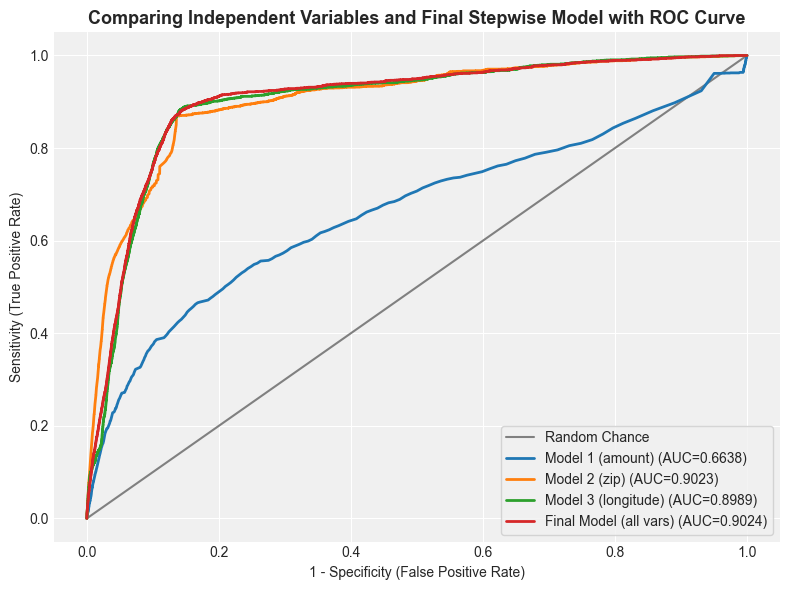

AUC values:
Model 1 (amount): 0.6638
Model 2 (zip): 0.9023
Model 3 (longitude): 0.8989
Final Model (all vars): 0.9024


In [30]:
plot_multiple_roc_sklearn(
    models=[model_1, model_2, model_3, model_final],
    scalers=[scaler_1, scaler_2, scaler_3, scaler_final],
    model_names=[
        "Model 1 (amount)",
        "Model 2 (zip)",
        "Model 3 (longitude)",
        "Final Model (all vars)"
    ],
    test_df=test_df,
    included_var_sets=[vars_1, vars_2, vars_3, vars_final],
    target_col="is_fraud"
)

共有 23 個變數可供建模
總共建立 24 個模型（含最終模型）


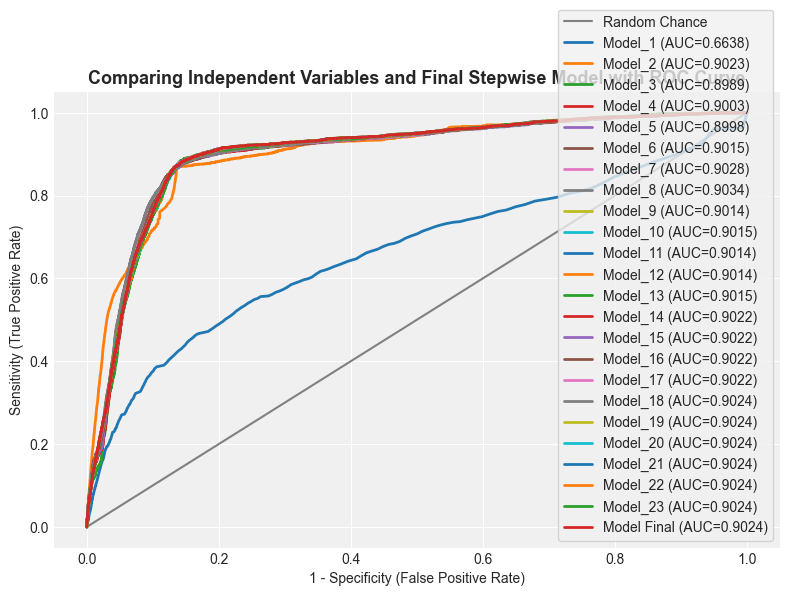

AUC values:
Model_1: 0.6638
Model_2: 0.9023
Model_3: 0.8989
Model_4: 0.9003
Model_5: 0.8998
Model_6: 0.9015
Model_7: 0.9028
Model_8: 0.9034
Model_9: 0.9014
Model_10: 0.9015
Model_11: 0.9014
Model_12: 0.9014
Model_13: 0.9015
Model_14: 0.9022
Model_15: 0.9022
Model_16: 0.9022
Model_17: 0.9022
Model_18: 0.9024
Model_19: 0.9024
Model_20: 0.9024
Model_21: 0.9024
Model_22: 0.9024
Model_23: 0.9024
Model Final: 0.9024


In [31]:
# 計算 included 長度
n_vars = len(included)
print(f"共有 {n_vars} 個變數可供建模")

# 建立模型與 scaler 的容器
models = []
scalers = []
model_names = []
included_var_sets = []

# 自動迴圈建立模型
for k in range(1, n_vars + 1):
    model_info = sklearn_logit_with_k(
        train_df, test_df, dep_var="is_fraud", included=included, k=k
    )
    _, _, _, model, scaler = model_info
    
    models.append(model)
    scalers.append(scaler)
    included_var_sets.append(included[:k])
    model_names.append(f"Model_{k}")

# 最後一個完整模型 (Final Model)
model_final_info = sklearn_logit_with_k(
    train_df, test_df, dep_var="is_fraud", included=included, k=314657018
)
_, _, _, model_final, scaler_final = model_final_info

models.append(model_final)
scalers.append(scaler_final)
included_var_sets.append(included)
model_names.append("Model Final")

print(f"總共建立 {len(models)} 個模型（含最終模型）")

# 🔹 繪製多模型 ROC 比較圖
plot_multiple_roc_sklearn(
    models=models,
    scalers=scalers,
    model_names=model_names,
    test_df=test_df,
    included_var_sets=included_var_sets,
    target_col="is_fraud"
)

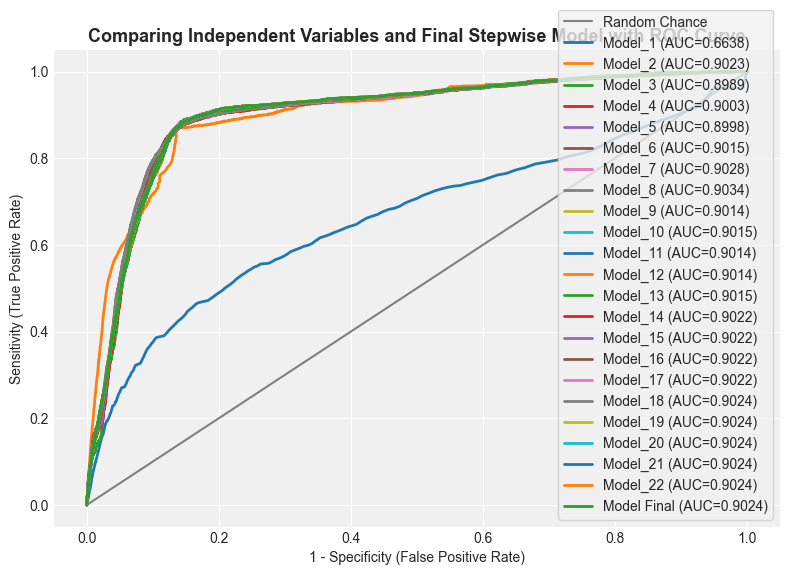

AUC values:
Model_1: 0.6638
Model_2: 0.9023
Model_3: 0.8989
Model_4: 0.9003
Model_5: 0.8998
Model_6: 0.9015
Model_7: 0.9028
Model_8: 0.9034
Model_9: 0.9014
Model_10: 0.9015
Model_11: 0.9014
Model_12: 0.9014
Model_13: 0.9015
Model_14: 0.9022
Model_15: 0.9022
Model_16: 0.9022
Model_17: 0.9022
Model_18: 0.9024
Model_19: 0.9024
Model_20: 0.9024
Model_21: 0.9024
Model_22: 0.9024
Model Final: 0.9024


/var/folders/yb/xnfk9z6x34527z3924bcjqcr0000gn/T/ipykernel_3877/2385880931.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'size': 5})  # 大約是預設的 0.7 倍


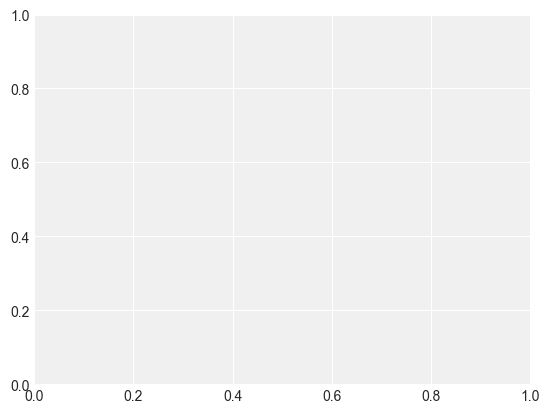

In [36]:
# 移除重複模型（例如 Model_23）
#duplicate_index = model_names.index("Model_23")
#del models[duplicate_index]
#del scalers[duplicate_index]
#del included_var_sets[duplicate_index]
#del model_names[duplicate_index]

# 🔹 繪製多模型 ROC 比較圖
plot_multiple_roc_sklearn(
    models=models,
    scalers=scalers,
    model_names=model_names,
    test_df=test_df,
    included_var_sets=included_var_sets,
    target_col="is_fraud"
)

# 🔹 調整圖例大小
import matplotlib.pyplot as plt
plt.legend(prop={'size': 5})  # 大約是預設的 0.7 倍
plt.show()


In [33]:
num_cols

Index(['transaction_id', 'client_id_x', 'card_id', 'amount', 'merchant_id',
       'zip', 'mcc_code', 'merchant_state_missing_flag', 'zip_missing_flag',
       'errors_missing_flag', 'use_chip_Chip Transaction',
       'use_chip_Online Transaction', 'use_chip_Swipe Transaction', 'is_fraud',
       'current_age', 'retirement_age', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'gender_Male', 'card_number', 'cvv',
       'num_cards_issued', 'credit_limit', 'card_type_Credit',
       'card_type_Debit', 'card_type_Debit (Prepaid)', 'card_brand_Amex',
       'card_brand_Discover', 'card_brand_Mastercard', 'card_brand_Visa',
       'has_chip_YES', 'is_fraud_missing_flag'],
      dtype='object')